# Use Kasumi (MISTy with sliding windows) on MIBI data

## Imports

In [1]:
library(mistyR)
library(tidyverse)
library(future)
library(proxy)
library(withr)
library(igraph)
library(ggplot2)

mistyR is able to run computationally intensive functions
  in parallel. Please consider specifying a future::plan(). For example by running
  future::plan(future::multisession) before calling mistyR functions.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix



Attaching package: ‘igraph’


The following objects are masked from ‘package:future’:

 

In [2]:
# Load your transformed cell table
cells = read_csv("../../data/cell_table_with_types_stage.csv")
head(cells)

New names:
• `` -> `...1`
Rows: 579011 Columns: 70
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (31): fov, annotation_t, annotation_scyan, consensus, annotation_consens...
dbl (37): ...1, CA9, nuclei, CD98, CytC, MSH2, MCT1, PDL1, PD1, ASCT2, LDH, ...
lgl  (2): Grade raw, pM group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,CA9,nuclei,CD98,CytC,MSH2,MCT1,PDL1,PD1,ASCT2,⋯,RAS Mutation RED,RAS Mutation RED 2,BRAF Mutation RED,HER2 Amplifikation,Age,Sex,MIBI,Tumor Size Group,Age Group,Stage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
0,0.02128943,0.04614832,0.006392956,0.01571343,0.02473370,0.0001934555,0.009022579,0.004549611,0.04586374,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3
1,0.01457781,0.03423819,0.008830998,0.10651270,0.06347377,0.0027742222,0.004172783,0.000000000,0.02873399,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3
2,0.11329879,0.06419776,0.034138213,0.01142891,0.06656348,0.0015064266,0.009497505,0.000000000,0.02825994,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3
3,0.12827739,0.09715288,0.040913454,0.03036816,0.01601639,0.0052802216,0.022267382,0.028413114,0.03409141,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3
4,0.10768224,0.05414692,0.070130227,0.09855133,0.08103716,0.0209243360,0.004453675,0.022994452,0.11757625,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3
5,0.10965646,0.01982199,0.026331486,0.06694059,0.02464267,0.0497367896,0.001608107,0.027431549,0.19049839,⋯,NA,NA,NA,NA,88,w,acquired,NA,70 and Over,pT3


In [3]:
# Exclude low epithelial abundance samples and SCT samples (start with "E1" or "E2")

# See StageXGB.ipynb
excluded_fovs = c('A2n','A3r','A4i','A5c','A7c','A7m','A8f','A9k','A9p','B1q','B2l',
                  'B2n','B3o','B4a','B4n','B5h','B5i','B5p','B6l','B7g','B7k','B7q',
                  'B8c','B9r','C2e','C9a','C9d','C9e','C9i','D1c','D1g','D2c','D3m',
                  'D4e','D6e','D6i','D7b','D8m','D9g','D9l')

cells <- cells %>% 
    filter(!(fov %in% excluded_fovs)) %>%
    filter(!grepl("^E[1-2]", fov))

In [4]:
# Drop cells with "Unclear" label
# Note that we use a fixed radius in the MISTy views, so removing
# these cells should not affect the interactions between annotated cells
cells <- cells %>% filter(annotation_consensus != "Unclear")

In [5]:
# Convert cells$Lineage to one-hot encoded columns
cells_one_hot <- cells %>%
  mutate(id = "...1") %>%  # Add an ID column to keep track of rows
  pivot_wider(names_from = annotation_consensus, values_from = annotation_consensus, values_fill = list(annotation_consensus = 0), values_fn = list(annotation_consensus = length)) %>%
  select(-id) %>% # Remove the ID column
  rename_with(~ gsub(" ", "_", .))  # Replace spaces with underscores in column names

In [6]:
paraview_l <- 120 # Distance in pixels up to which an effect will be considered in the paraview
juxtaview_l <- 40 # Distance in pixels up to which a cell is considered a direct neighbor
panel = unique(cells$annotation_consensus)
outputfile = "misty_colorectal_lineage_multiview_no_unclear.sqm"

In [7]:
# Expected data is a list of tibbles with each one containing the marker expressions (columns) per cell (rows) for a fov
markers <- cells_one_hot %>% group_by(fov) %>% select(all_of(panel)) %>% group_split(.keep = FALSE)

Adding missing grouping variables: `fov`


In [8]:
# Coordinates of each cell
positions <- cells_one_hot %>% group_by(fov) %>% select(c("centroid-0", "centroid-1")) %>% group_split(.keep = FALSE)

Adding missing grouping variables: `fov`


In [9]:
# Extract the names of the FOVs in the same order as the markers and positions tables
fov_names <- cells_one_hot %>% group_by(fov) %>% summarise(fov = first(fov)) %>% pull(fov)

In [ ]:
outputs <- seq_along(markers) %>% walk(
    function(i) {
    misty.views <- create_initial_view(markers[[i]]) %>%
        add_paraview(positions[[i]], paraview_l,
            family = "gaussian", cached = TRUE,
            prefix = "p.", zoi = juxtaview_l,
        ) %>%
        add_juxtaview(positions[[i]], juxtaview_l,
            prefix = "l."
        )

    folders <- run_misty(misty.views,
        sample.id = fov_names[i],
        results.db = outputfile,
        bypass.intra = TRUE,
        cv.strict = FALSE,
        sqlite_timeout = 10000
    )})

In [10]:
misty.results <- collect_results(outputfile)








Aggregating



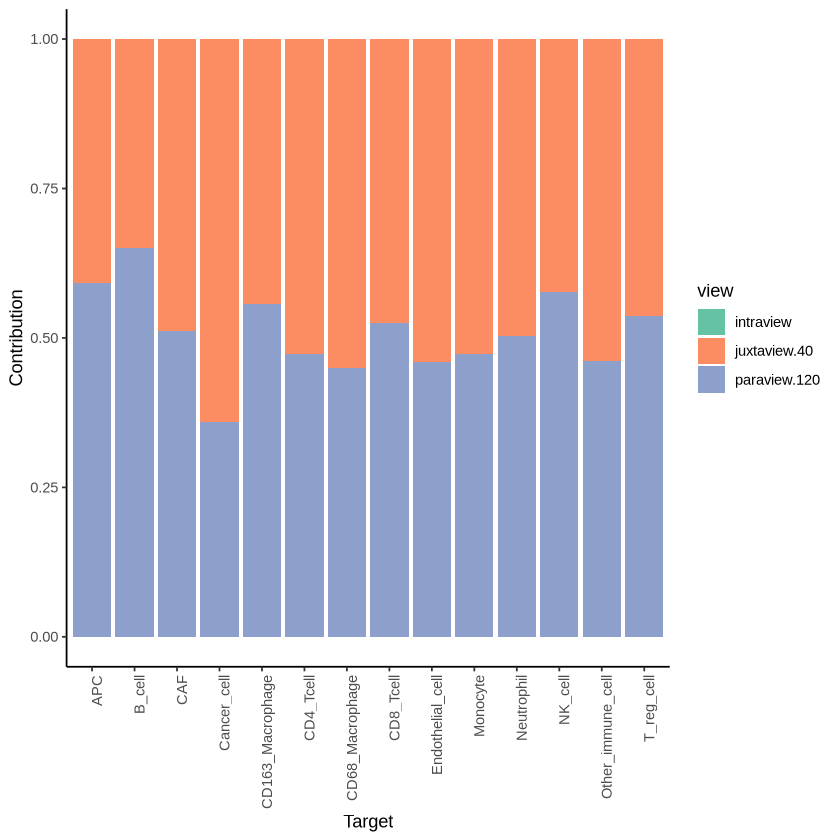

In [11]:
plot_view_contributions(misty.results)

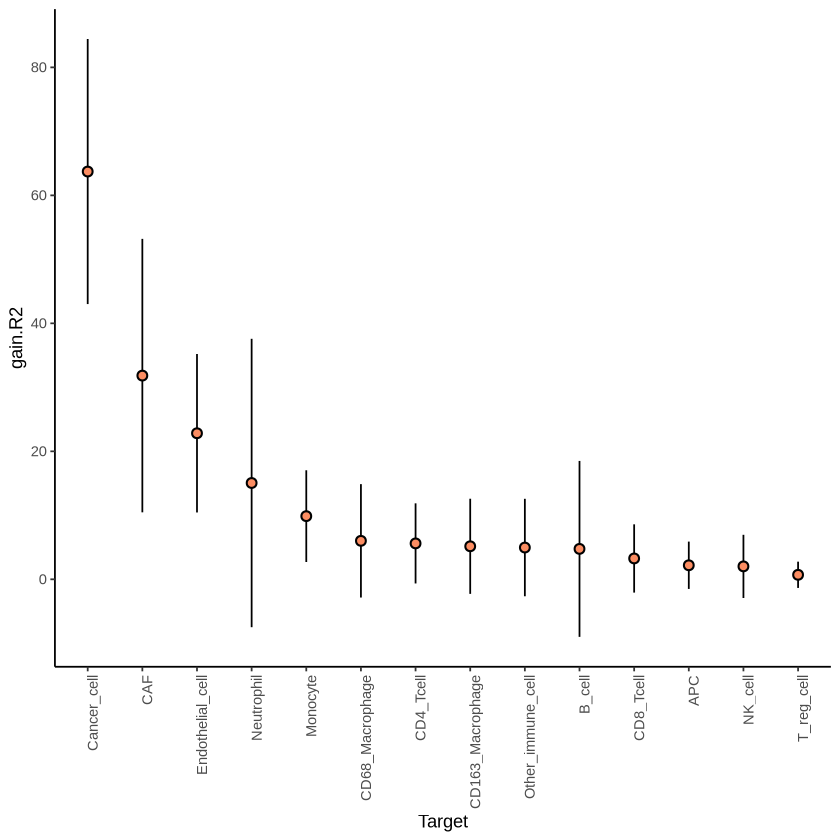

In [12]:
plot_improvement_stats(misty.results)

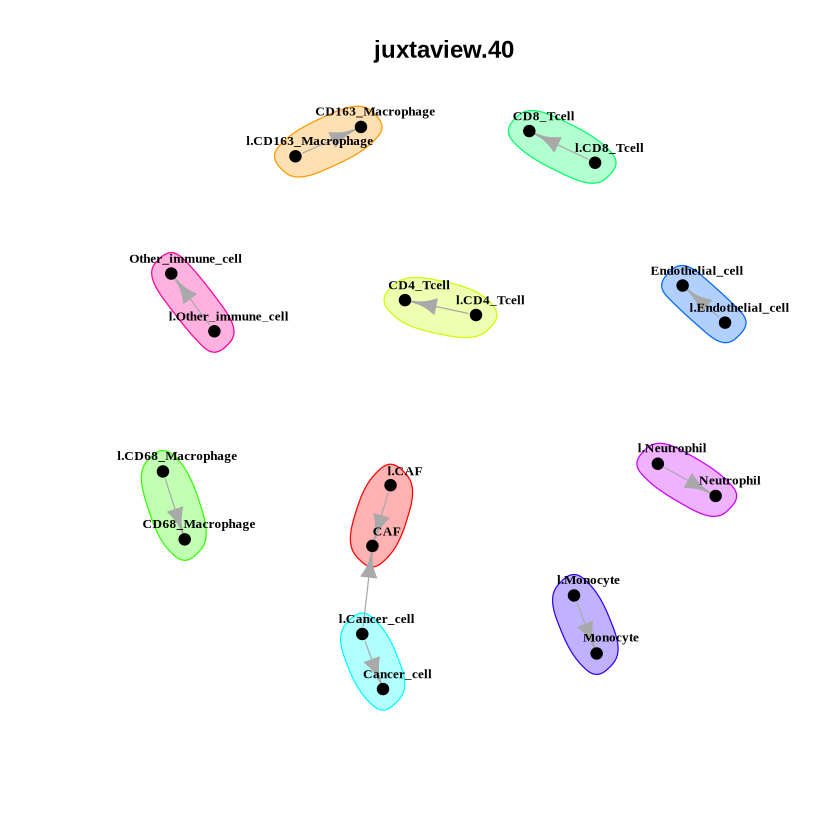

In [13]:
plot_interaction_communities(misty.results, view = "juxtaview.40")

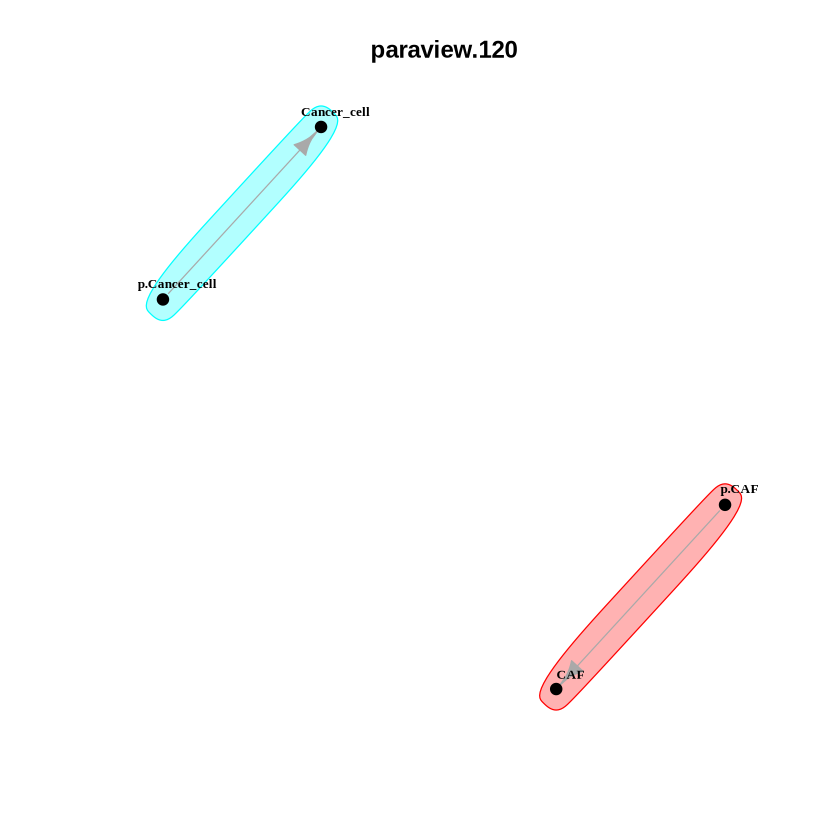

In [14]:
plot_interaction_communities(misty.results, view = "paraview.120")

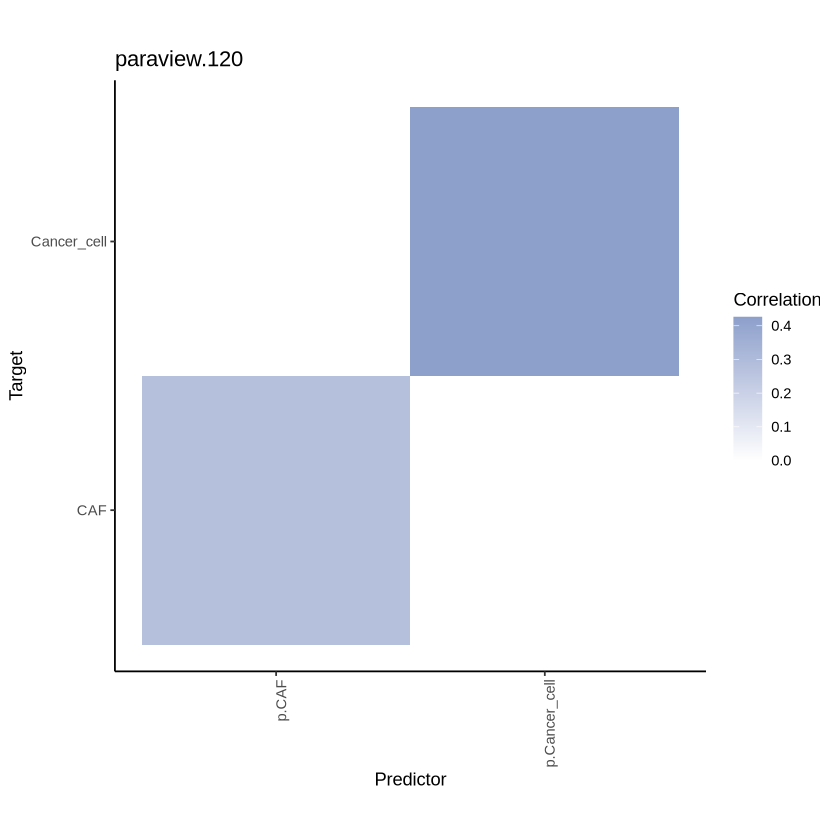

In [15]:
plot_interaction_heatmap(misty.results, "paraview.120", clean = TRUE, correlation = TRUE)

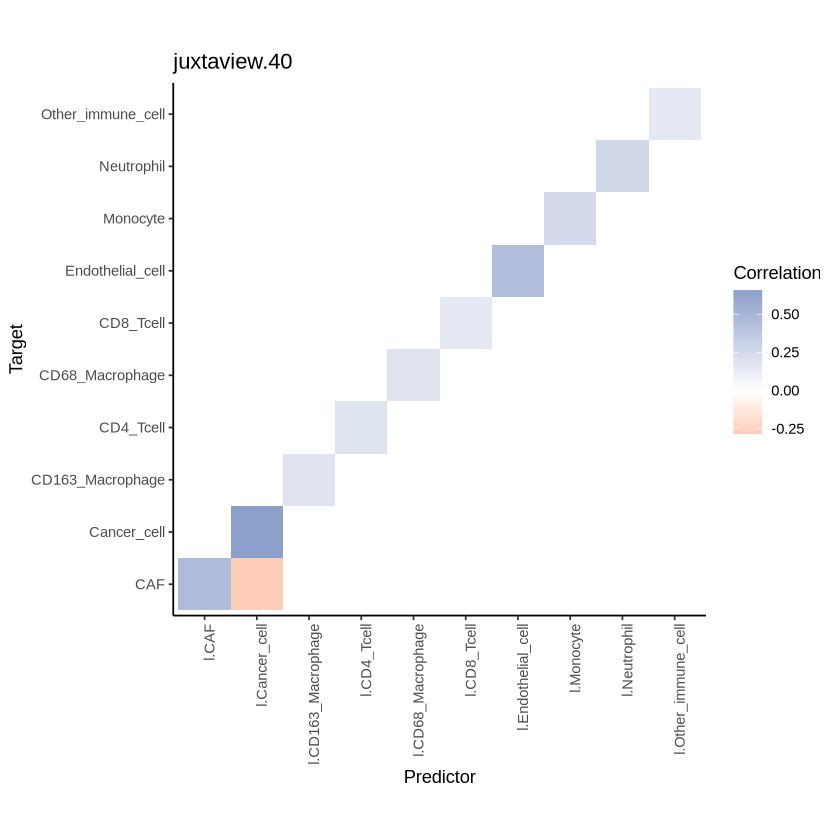

In [16]:
plot_interaction_heatmap(misty.results, "juxtaview.40", clean = TRUE, correlation = TRUE)

## Split between cancer and healthy samples

In [17]:
library(DBI)
library(RSQLite)
library(dplyr)

In [18]:
describe_sample_type <- function(dbfile, is_healthy = TRUE) {
  # Get all samples
  dbcon <- dbConnect(RSQLite::SQLite(), dbfile)
  samples <- dbGetQuery(dbcon, "SELECT DISTINCT sample FROM contributions") %>% 
    unlist()
  dbDisconnect(dbcon)
  
  # Create pattern based on sample type
  pattern <- if(is_healthy) {
    # Match E3 or E4 prefix
    paste0("(", paste0(
      grep("^(E3|E4)", samples, value = TRUE),
      collapse = "|"
    ), ")")
  } else {
    # Match anything not starting with E3 or E4
    paste0("(", paste0(
      grep("^(?!(E3|E4))", samples, value = TRUE, perl = TRUE),
      collapse = "|"
    ), ")")
  }
  
  # Collect filtered results
  collect_results(dbfile, pattern)
}

In [19]:
healthy_results <- describe_sample_type(outputfile, is_healthy = TRUE)








Aggregating



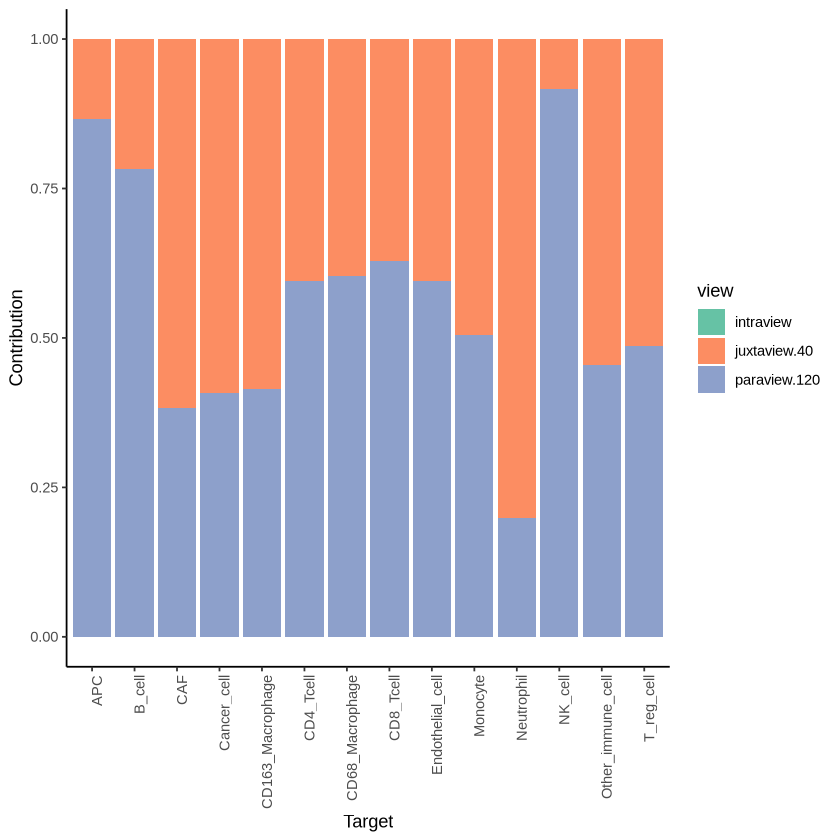

In [20]:
plot_view_contributions(healthy_results)
# ggsave(filename = "../../figures/fig4/misty_lineage_healthy_contrib.pdf", 
#         dpi = 300)

In [21]:
tumor_results <- describe_sample_type(outputfile, is_healthy = FALSE)






Aggregating



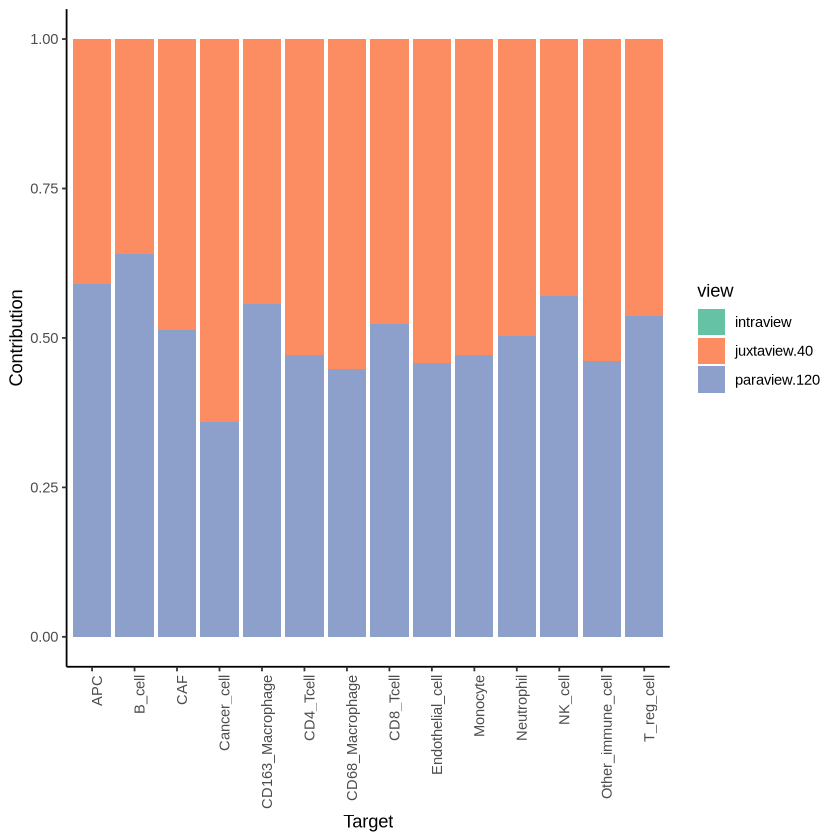

In [22]:
plot_view_contributions(tumor_results)
# ggsave(filename = "../../figures/fig4/misty_lineage_tumor_contrib.pdf", 
#         dpi = 300)

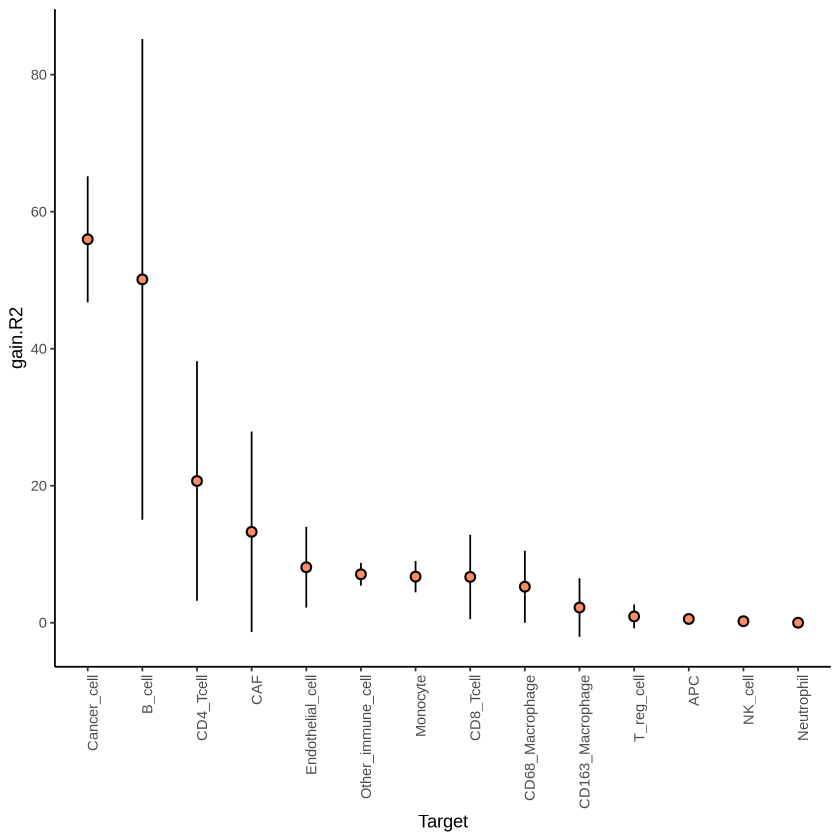

In [23]:
plot_improvement_stats(healthy_results)
ggsave(filename = "../../figures/fig4/misty_lineage_healthy_improvements.pdf", width = 4, height = 4)

In [24]:
x <- healthy_results$improvements
x <- x[x$measure == "gain.R2",]
# Aggregate across `sample` and take the mean `value`
x <- x %>%
    group_by(target) %>%
    summarise(mean_value = mean(value, na.rm = TRUE)) %>%
    arrange(desc(mean_value))
# Display the top 6 samples with the highest mean gain.R2
head(x, 6)

target,mean_value
<chr>,<dbl>
Cancer_cell,55.971713
B_cell,50.116005
CD4_Tcell,20.689509
CAF,13.271255
Endothelial_cell,8.099464
Other_immune_cell,7.075416


In [25]:
pdf("../../figures/fig4/misty_lineage_healthy_para_net.pdf")
plot_interaction_communities(healthy_results, 
    view = "paraview.120", 
    path = "../../data/misty_lineage_healthy_para_net.graphml")
dev.off()

png 
  2

In [26]:
pdf("../../figures/fig4/misty_lineage_healthy_juxta_net.pdf")
plot_interaction_communities(healthy_results, 
    view = "juxtaview.40",
    path = "../../data/misty_lineage_healthy_juxta_net.graphml")
dev.off()

png 
  2

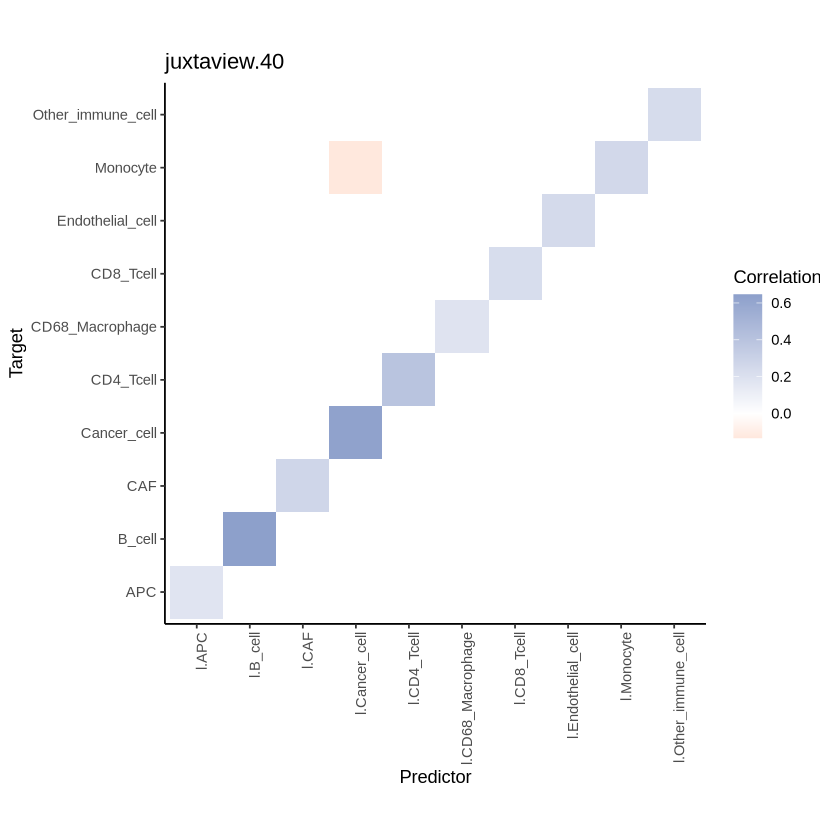

Saving 6.67 x 6.67 in image


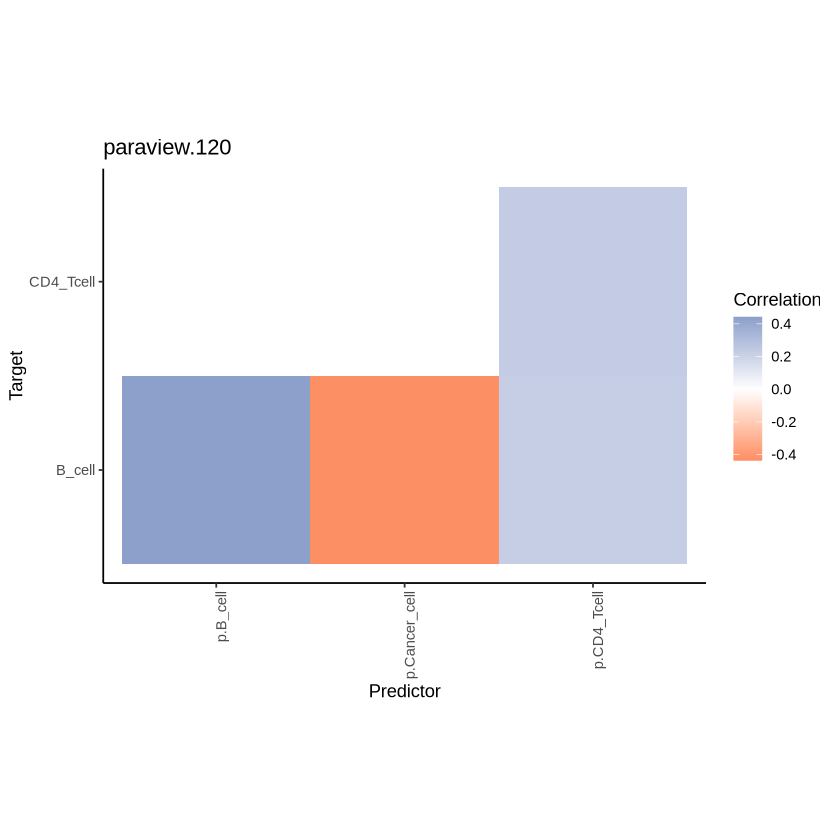

In [27]:
plot_interaction_heatmap(healthy_results, "juxtaview.40", clean = TRUE, correlation = TRUE)
plot_interaction_heatmap(healthy_results, "paraview.120", clean = TRUE, correlation = TRUE)
ggsave(filename = "../../figures/fig4/misty_lineage_healthy_para_heatmap.pdf", 
        dpi = 300)

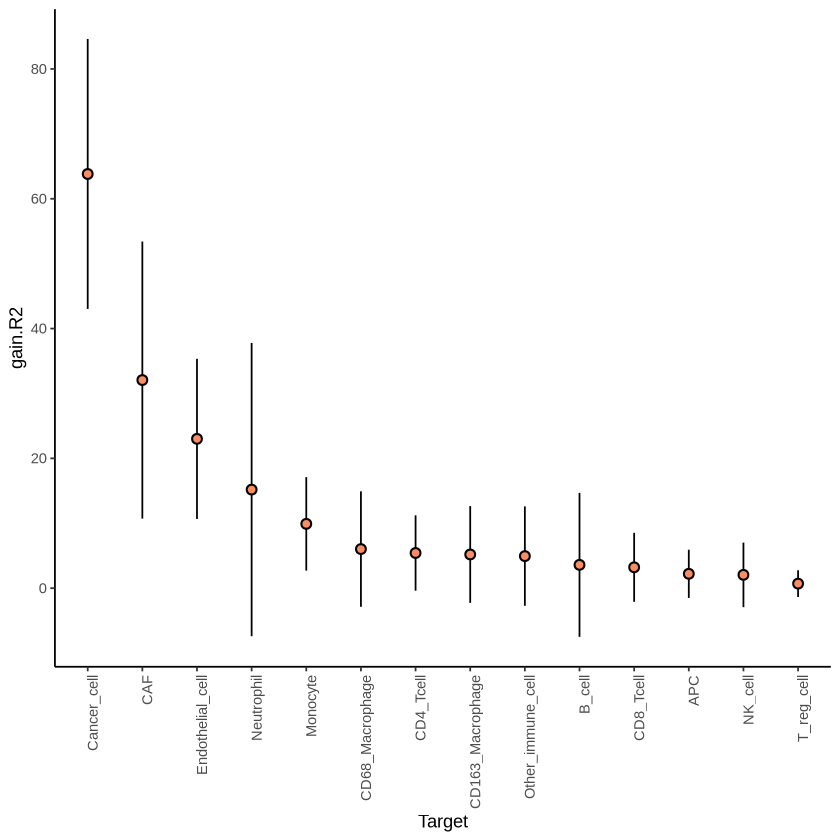

In [28]:
plot_improvement_stats(tumor_results)
ggsave(filename = "../../figures/fig4/misty_lineage_tumor_improvements.pdf", width = 4, height = 4)

In [29]:
pdf("../../figures/fig4/misty_lineage_tumor_para_net.pdf")
plot_interaction_communities(tumor_results, 
    view = "paraview.120",
    path = "../../data/misty_lineage_tumor_para_net.graphml")
dev.off()

png 
  2

In [30]:
pdf("../../figures/fig4/misty_lineage_tumor_juxta_net.pdf")
plot_interaction_communities(tumor_results, 
    view = "juxtaview.40",
    path = "../../data/misty_lineage_tumor_juxta_net.graphml")
dev.off()

png 
  2

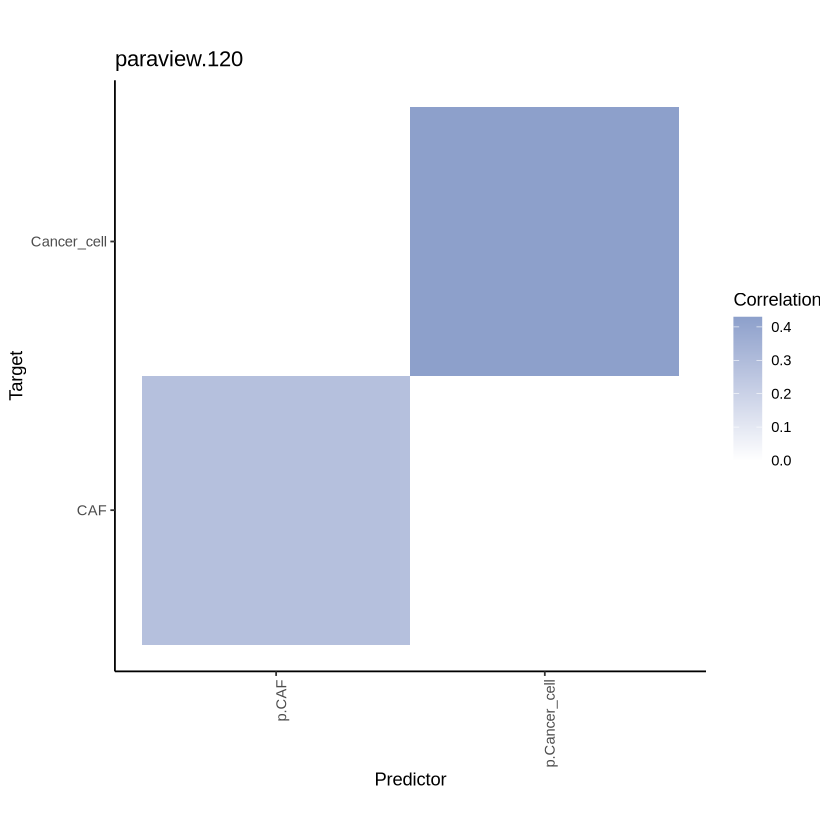

Saving 6.67 x 6.67 in image


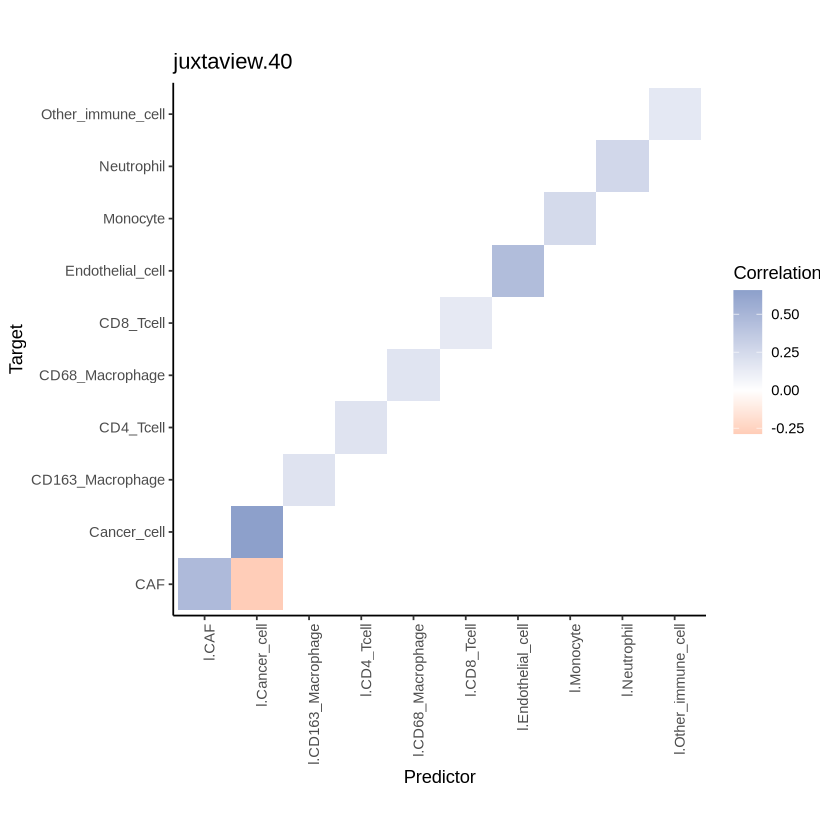

In [31]:
plot_interaction_heatmap(tumor_results, "paraview.120", clean = TRUE, correlation = TRUE)
plot_interaction_heatmap(tumor_results, "juxtaview.40", clean = TRUE, correlation = TRUE)
ggsave(filename = "../../figures/fig4/misty_lineage_tumor_juxta_heatmap.pdf", 
        dpi = 300)

As B cells seem to differ, we list potentially interesting FOVs to look at.

In [32]:
cells_one_hot %>% 
    group_by(fov) %>% 
    summarise(
        n_cells = n(),
        mean_cd20 = mean(B_cell)
    ) %>% # Sort tibble by mean_cd20
    arrange(mean_cd20)

fov,n_cells,mean_cd20
<chr>,<int>,<dbl>
A1a,1370,0
A1c,1404,0
A1d,955,0
A1e,1472,0
A1f,1046,0
A1h,795,0
A1i,1074,0
A1l,1338,0
A1m,1255,0


We are also interested in the CAF-cancer exclusion in tumor samples. Here we identify FOVs to illustrate these changes:

In [33]:
fov_features <- extract_signature(misty.results, type = "i", intersect.targets = FALSE, trim = 1)
print(dim(fov_features))
fov_features[is.na(fov_features)] <- floor(min(fov_features %>% select(-sample), na.rm = TRUE))
fov_features <- fov_features %>% mutate(across(!sample, ~ ifelse(.x <= 0.9, 0, .x)))
# Drop columns with all zeros
keep <- names(which(fov_features %>% select(-sample, -contains("intra_")) %>% colSums() > 0))
fov_features <- fov_features %>%
    select(sample, all_of(keep))

[1] 423 365


In [34]:
# Select the pattern of interest
imp <- fov_features %>%
    select(c("sample", "juxtaview.40_l.Cancer_cell_CAF")) %>%
    rename(Importance = juxtaview.40_l.Cancer_cell_CAF) %>%
    arrange(desc(Importance))
imp %>% head(12)
imp[imp$Importance > 0,] %>% tail(12)

sample,Importance
<chr>,<dbl>
B3i,3.053879
D9h,2.999535
A2b,2.951018
C5e,2.923873
B7r,2.797752
B1p,2.787411
B5b,2.764851
C2g,2.685420
D2l,2.684509


sample,Importance
<chr>,<dbl>
C9k,0.9734838
A1a,0.9733331
A8h,0.9506605
C7k,0.9497758
B6h,0.9401652
A8a,0.9324841
B8l,0.9274909
D4k,0.9146609
D5b,0.9136234


Finally, we export MISTy interaction scores to serve as features for classifiers (see *StageXGB.ipynb*).

In [35]:
fov_features <- extract_signature(misty.results, type = "i", intersect.targets = FALSE, trim = 1)
print(dim(fov_features))
fov_features[is.na(fov_features)] <- floor(min(fov_features %>% select(-sample), na.rm = TRUE))
fov_features <- fov_features %>% mutate(across(!sample, ~ ifelse(.x <= 0.9, 0, .x)))
# Drop columns with all zeros
keep <- names(which(fov_features %>% select(-sample, -contains("intra_")) %>% colSums() > 0))
fov_features %>%
    select(sample, all_of(keep)) %>%
    write_csv("../../data/misty_lineage_features.csv")

[1] 423 365
